# Unsupervised dimensionality reduction via principal component analysis (PCA)

#### let’s summarize the approach in a few simple steps:
1. Standardize the d-dimensional dataset.
2. Construct the covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
5. Select k eigenvectors, which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (𝑘<=d).
6. Construct a projection matrix, W, from the “top” k eigenvectors.
7. Transform the d-dimensional input dataset, X, using the projection matrix, W, to obtain the
new k-dimensional feature subspace.

## Extracting the principal components step-by-step

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

Splitting the data into 70% training and 30% test subsets.

In [2]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

Standardizing the data.

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Eigendecomposition of the covariance matrix.

In [4]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]


The numpy.linalg.eig function was designed to operate on both symmetric and non-sym-
metric square matrices.

A related function, numpy.linalg.eigh, has been implemented to decompose Hermetian
matrices, which is a numerically more stable approach to working with symmetric matri-
ces such as the covariance matrix; numpy.linalg.eigh always returns real eigenvalues.

<br>

## Total and explained variance

In [5]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

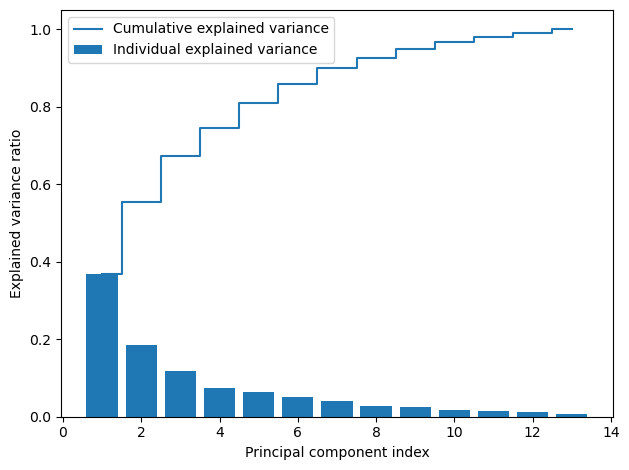

In [6]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
        label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

we can see that the first two principal components combined explain almost 60 percent of the
variance in the dataset

<br>

## Feature transformation

In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [8]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218 -0.50303478]
 [ 0.24724326 -0.16487119]
 [-0.02545159 -0.24456476]
 [ 0.20694508  0.11352904]
 [-0.15436582 -0.28974518]
 [-0.39376952 -0.05080104]
 [-0.41735106  0.02287338]
 [ 0.30572896 -0.09048885]
 [-0.30668347 -0.00835233]
 [ 0.07554066 -0.54977581]
 [-0.32613263  0.20716433]
 [-0.36861022  0.24902536]
 [-0.29669651 -0.38022942]]


In [9]:
X_train_std[0].dot(w)

array([ 2.38299011, -0.45458499])

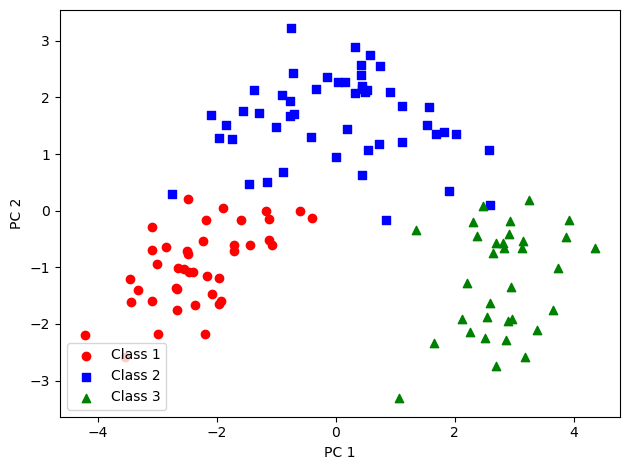

In [10]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

<br>
<br>

## Principal component analysis in scikit-learn

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

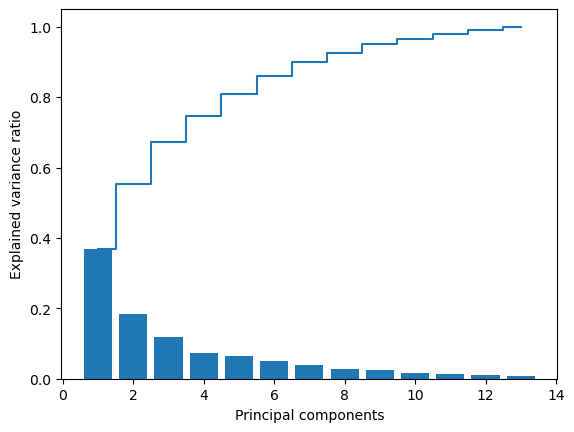

In [12]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [13]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

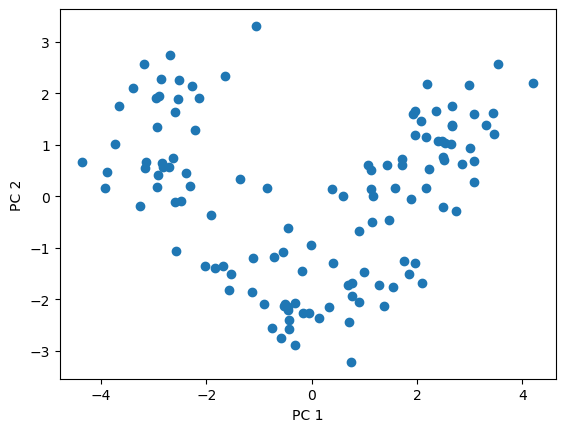

In [14]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

Training logistic regression classifier using the first 2 principal components.

In [16]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


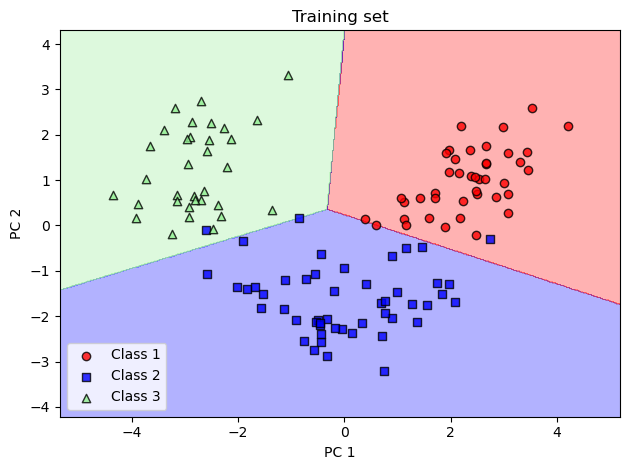

In [17]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.title('Training set')
plt.tight_layout()
plt.show()

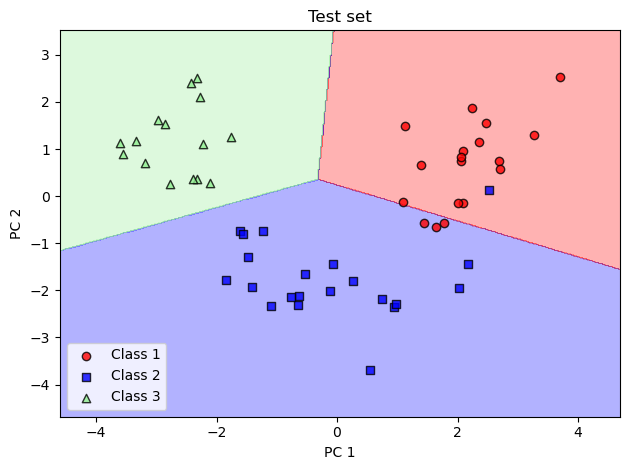

In [18]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.title('Test set')
plt.tight_layout()
plt.show()

In [19]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

we set n_components=None when we initialized the PCA class so that it will return all principal
components in a sorted order, instead of performing a dimensionality reduction.

## Assessing feature contributions

Sometimes, we are interested to know about how much each original feature contributes to a given principal component. These contributions are often called loadings.

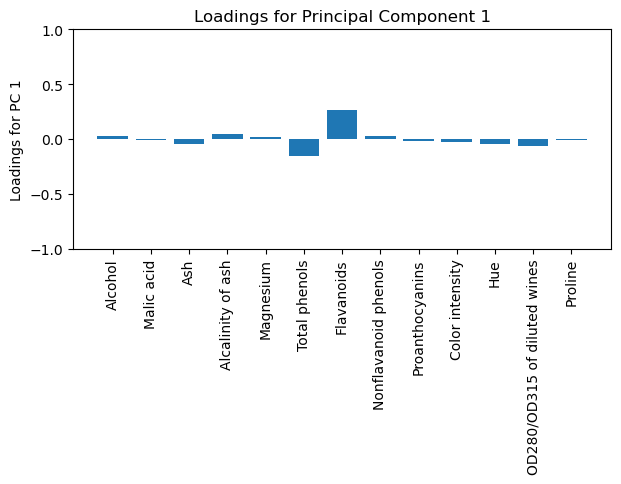

In [20]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.title('Loadings for Principal Component 1')
plt.show()

In [21]:
loadings[:, 0]

array([ 0.03098632, -0.00864629, -0.04681301,  0.04279186,  0.02217158,
       -0.15082665,  0.26713687,  0.03139989, -0.02205313, -0.02864042,
       -0.04232466, -0.06153723, -0.0039718 ])

pca.components_ represents the eigenvectors and pca.explained_variance_ represents the eigenvalues

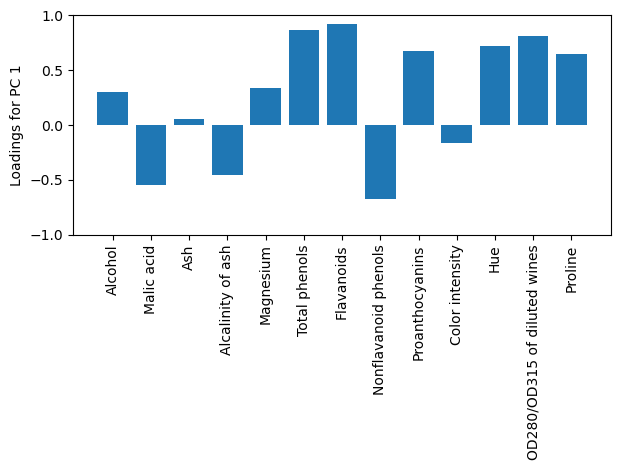

In [22]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(13), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

we can see that, for example, Alcohol has a negative correlation with the first principal
component (approximately –0.3), whereas Malic acid has a positive correlation (approximately 0.54).
Note that a value of 1 describes a perfect positive correlation whereas a value of –1 corresponds to a
perfect negative correlation

<br>
<br>

# Supervised data compression via linear discriminant analysis (LDA)

## Principal component analysis versus linear discriminant analysis

- Both PCA and LDA are linear transformation techniques that can be used to reduce the number of di-
mensions in a dataset; the former is an unsupervised algorithm, whereas the latter is supervised. 

- LDA can be used as a technique for feature extraction to increase computational efficiency and reduce
the degree of overfitting due to the curse of dimensionality in non-regularized models. The general
concept behind LDA is very similar to PCA, but whereas PCA attempts to find the orthogonal component
axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes
class separability.


## The inner workings of linear discriminant analysis

#### let’s briefly summarize the main steps that are required to perform LDA:
1. Standardize the d-dimensional dataset (d is the number of features).  
2. For each class, compute the d-dimensional mean vector.  
3. Construct the between-class scatter matrix, SB, and the within-class scatter matrix, SW.  
4. Compute the eigenvectors and corresponding eigenvalues of the matrix, 𝑺𝑾⁻¹𝑺𝐵.  
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.  
6. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d×k-dimensional transformation matrix, W; the eigenvectors are the columns of this matrix.  
7. Project the examples onto the new feature subspace using the transformation matrix, W.  


<br>
<br>

## Computing the scatter matrices

##### Calculate the mean vectors for each class:

$𝒎_𝑖 = 1/n_i ∑ 𝒙_𝑚$      
(ith class)

In [23]:
np.set_printoptions(precision=4)

mean_vecs = []
# we have three classes in the Wine dataset
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



##### Compute the within-class scatter matrix:

$𝑺_𝑊 = ∑ 𝑺_𝑖$

$𝑺_𝑖 = ∑ (𝒙 - m_𝑖)(𝒙 - m_𝑖 )^𝑇$

In [24]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: '
    f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


In [25]:
print('Class label distribution:',  
      np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


The assumption that we are making when we are computing the scatter matrices is that the class labels
in the training dataset are uniformly distributed.

Better: covariance matrix since classes are not equally distributed:

Thus, we want to scale the individual scatter matrices, Si, before we sum them up as the scatter matrix,
SW. When we divide the scatter matrices by the number of class-examples, ni, we can see that com-
puting the scatter matrix is in fact the same as computing the covariance matrix, Σ𝑖 —the covariance matrix is
normalized version of scatter matrix.

- scaled within-class scatter matrix = covariance matrix

In [26]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: '
    f'{S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


##### Compute the between-class scatter matrix:

$𝑺_𝐵 = ∑ 𝑛_𝑖(𝒎_𝑖 − 𝒎)(𝒎_𝑖 − 𝒎)^𝑇$

In [27]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # make column vector

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: '
    f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


<br>
<br>

## Selecting linear discriminants for the new feature subspace

The remaining steps of the LDA are similar to the steps of the PCA. However, instead of performing
the eigendecomposition on the covariance matrix, we solve the generalized eigenvalue problem of
the matrix $S_W^{-1}S_B$:

In [38]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

Sort eigenvectors in descending order of the eigenvalues:

In [39]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
            for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.76152218979382
2.5481445655158925e-14
2.5481445655158925e-14
2.338176411255993e-14
2.338176411255993e-14
1.4368252223521912e-14
1.4368252223521912e-14
6.3737818001526064e-15
4.514488639250919e-15
4.514488639250919e-15
2.5784328775550555e-16
0.0


- In LDA, the number of linear discriminants is at most c – 1, where c is the number of class labels, since
the in-between scatter matrix, SB, is the sum of c matrices with rank one or less. We can indeed see
that we only have two nonzero eigenvalues (the eigenvalues 3-13 are not exactly zero, but this is due
to the floating-point arithmetic in NumPy.)

- **Collinearity**
:Note that in the rare case of perfect collinearity (all aligned example points fall on a
straight line), the covariance matrix would have rank one, which would result in only one
eigenvector with a nonzero eigenvalue.

To measure how much of the class-discriminatory information is captured by the linear discriminants
(eigenvectors), let’s plot the linear discriminants by decreasing eigenvalues,

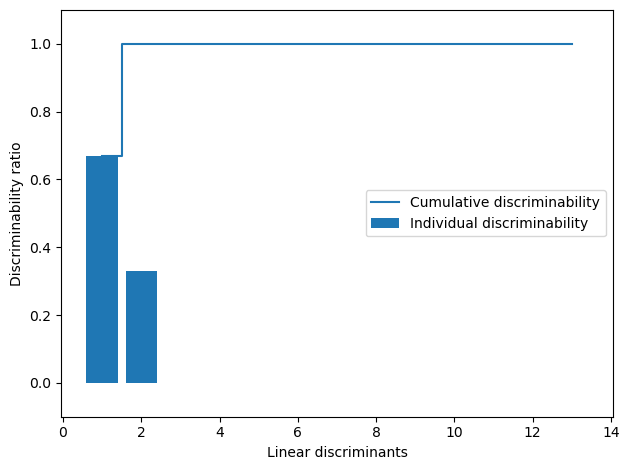

In [40]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
        label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [41]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
            eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


<br>
<br>

## Projecting examples onto the new feature space

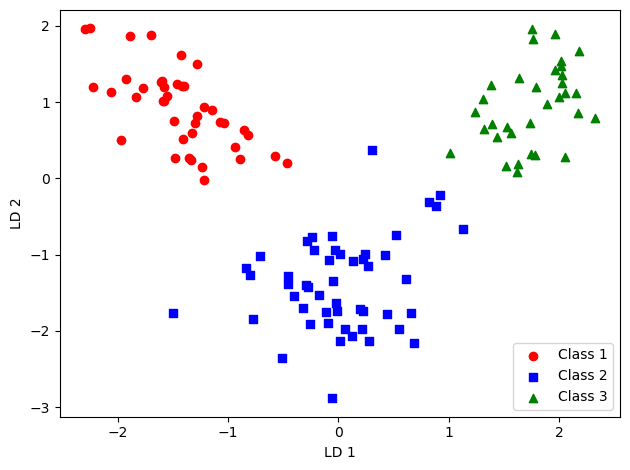

In [42]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

the three Wine classes are now perfectly linearly separable in the new
feature subspace

<br>
<br>

## LDA via scikit-learn

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


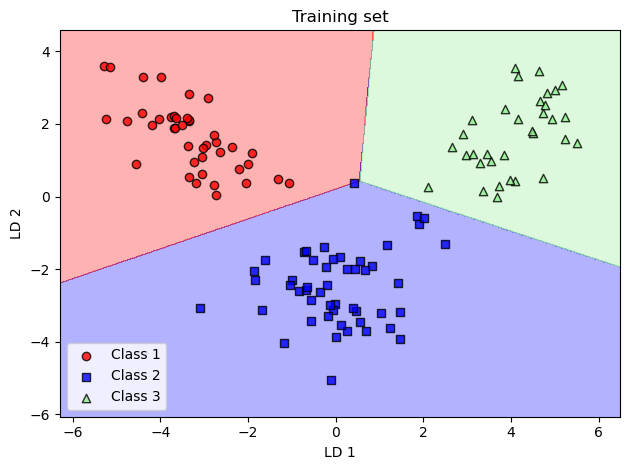

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title('Training set')
plt.tight_layout()
plt.show()

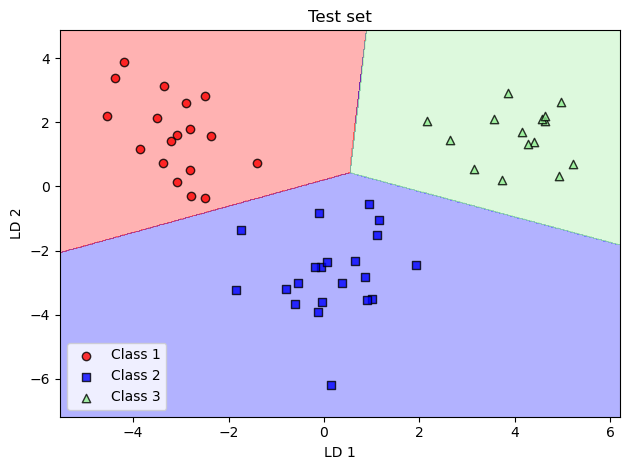

In [45]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title('Test set')
plt.tight_layout()
plt.show()

the logistic regression classifier is able to get a perfect accuracy score for
classifying the examples in the test dataset by only using a two-dimensional feature subspace, instead
of the original 13 Wine features

<br>
<br>